<a href="https://colab.research.google.com/github/marreapato/Forecasting-BVSP-Deep-Learning/blob/main/Baseline_Com_Lags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tentando Aplicar o Shap

In [81]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU# captum (biblioteca de interpretação pytorch)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Download data for the stock (I'm using the Bovespa index as an example)
data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data = data[['Close']]





[*********************100%%**********************]  1 of 1 completed


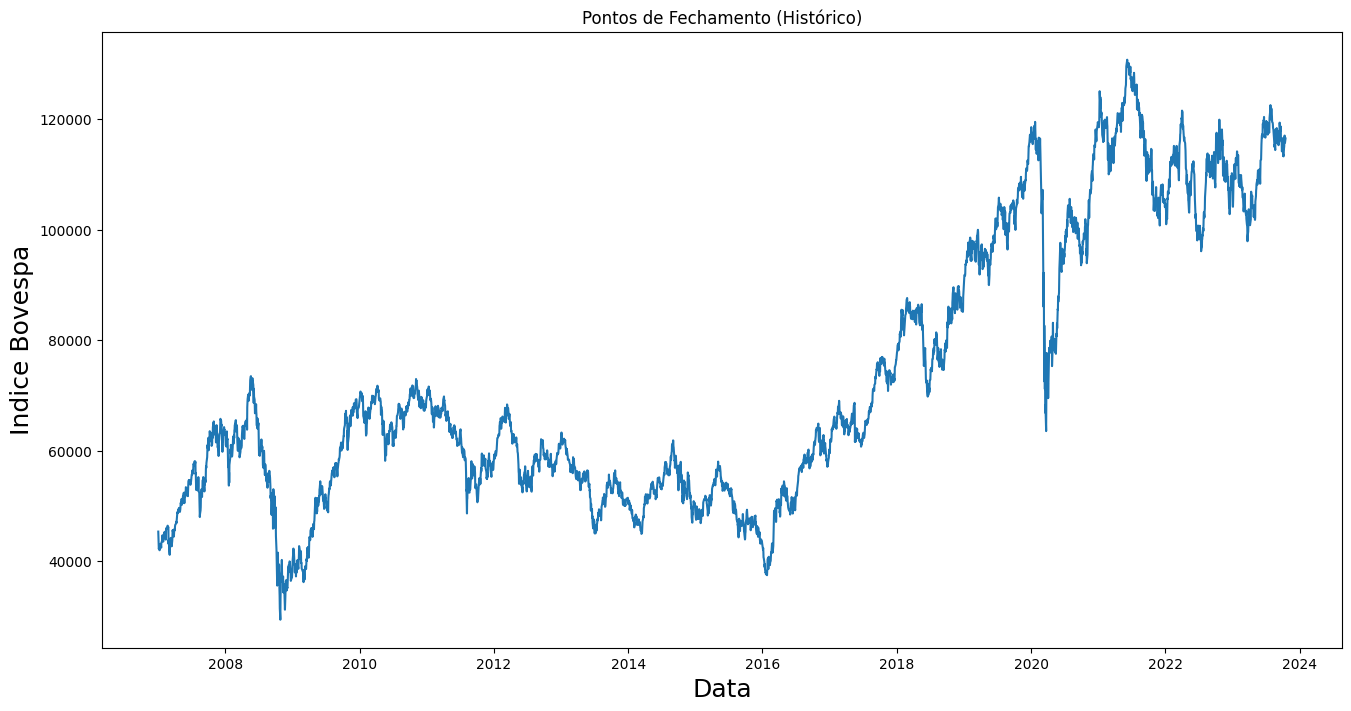

In [82]:
plt.figure(figsize=(16,8))
plt.title("Pontos de Fechamento (Histórico)")
plt.plot(data["Close"])
plt.xlabel("Data",fontsize=18)
plt.ylabel("Indice Bovespa",fontsize=18)
plt.show()

In [83]:
# Normalize the data
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))#use fit only in training that is wrong

def create_lagged_dataframe(data, lags, include_lag0=False):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data['Close']

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}'] = lagged_data['Close'].shift(lag)

    return lagged_data
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

<ipython-input-83-5abebc004b60>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))#use fit only in training that is wrong


In [84]:
from sklearn.model_selection import train_test_split

# Create lag features for the entire dataset
look_back = 60
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data, look_back, include_lag0)
lagged_data = lagged_data.dropna()  # Drop rows with NaN values

# Split the lagged data into features (X) and the target variable (Y)
X = lagged_data.drop(columns='Close').values
Y = lagged_data['Close'].values

# Split the data into training and testing sets
test_size = 0.2  # You can adjust the test size as needed
random_state = 42  # Set a random state for reproducibility

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=test_size, random_state=random_state)

print("TrainX shape:", trainX.shape)
print("TrainY shape:", trainY.shape)
print("TestX shape:", testX.shape)
print("TestY shape:", testY.shape)

TrainX shape: (3275, 60)
TrainY shape: (3275,)
TestX shape: (819, 60)
TestY shape: (819,)


In [85]:
trainX.shape

(3275, 60)

In [86]:
trainX = np.array(trainX)
testX = np.array(testX)

In [87]:
# Reshape the input data for LSTM and GRU models
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Define the GRU model
def GRU_Model(output_window):
    model = Sequential()
    model.add(GRU(128, return_sequences=False, input_shape=(1, look_back)))
    model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the LSTM model
def LSTM_Model(output_window):
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(1, look_back)))
    model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the baseline model
def baseline_model(output_window):
    last_known_value = trainY[-1]
    return np.full((len(testY), output_window), last_known_value)

# Train and evaluate the models
output_window = 1
gru_model = GRU_Model(output_window)
lstm_model = LSTM_Model(output_window)

gru_model.fit(trainX, trainY, epochs=3, batch_size=64)
lstm_model.fit(trainX, trainY, epochs=3, batch_size=64)

gru_predictions = gru_model.predict(testX)
lstm_predictions = lstm_model.predict(testX)
baseline_predictions = baseline_model(output_window)

# Inverse transform the predictions
gru_predictions = scaler.inverse_transform(gru_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
baseline_predictions = scaler.inverse_transform(baseline_predictions)



Epoch 1/3
52/52 [==============================] - 2s 4ms/step - loss: 0.0128
Epoch 2/3
52/52 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 3/3
52/52 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 1/3
52/52 [==============================] - 2s 4ms/step - loss: 0.0151
Epoch 2/3
52/52 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 3/3
26/26 [==============================] - 1s 3ms/step


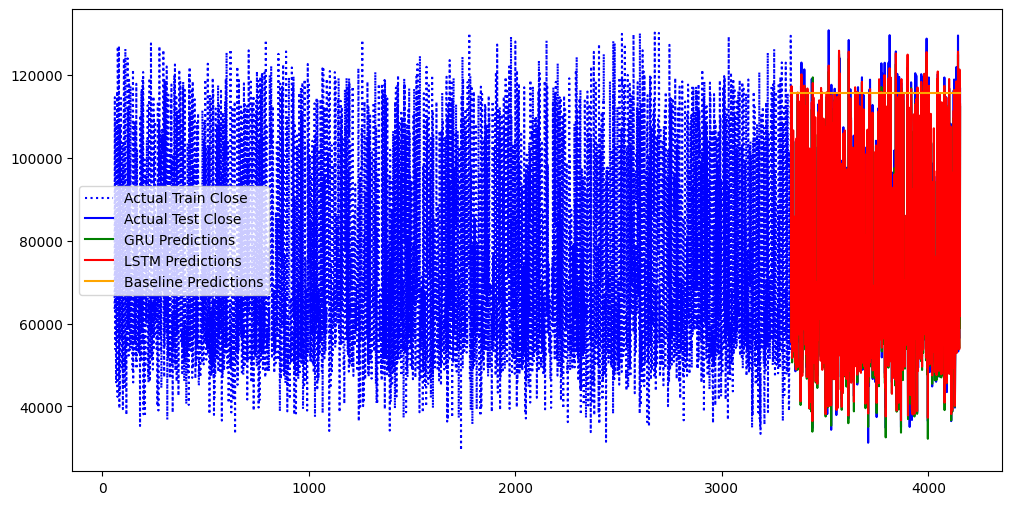

In [88]:
 #Inverse transform both train and test data
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = range(len(data) - len(testY) - len(trainY), len(data) - len(testY))
time_index_test = range(len(data) - len(testY), len(data))

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, trainY, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, testY, label='Actual Test Close', color='blue')
plt.plot(time_index_test, gru_predictions, label='GRU Predictions', color='green')
plt.plot(time_index_test, lstm_predictions, label='LSTM Predictions', color='red')
plt.plot(time_index_test, baseline_predictions, label='Baseline Predictions', color='orange')
plt.legend()
plt.show()

In [89]:
# Calculate the mean squared error for each model
gru_mse = mean_squared_error(testY, gru_predictions)
lstm_mse = mean_squared_error(testY, lstm_predictions)
baseline_mse = mean_squared_error(testY, baseline_predictions)

# Compare the models using Mean Squared Error
print("GRU Model RMSE: ", np.sqrt(gru_mse))
print("LSTM Model RMSE: ", np.sqrt(lstm_mse))
print("Baseline Model RMSE: ", np.sqrt(baseline_mse))


GRU Model RMSE:  3296.938205069027
LSTM Model RMSE:  3509.49490456046
Baseline Model RMSE:  49922.9737631537


In [90]:
# Calculate the Mean Absolute Percentage Error (MAPE) for each model
def calculate_mape(true_values, predicted_values):
    abs_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(abs_percentage_errors) * 100  # Convert to percentage
    return mape

gru_mape = calculate_mape(testY, gru_predictions)
lstm_mape = calculate_mape(testY, lstm_predictions)
baseline_mape = calculate_mape(testY, baseline_predictions)

# Compare the models using Mean Absolute Percentage Error
print("GRU Model MAPE: {:.2f}%".format(gru_mape))
print("LSTM Model MAPE: {:.2f}%".format(lstm_mape))
print("Baseline Model MAPE: {:.2f}%".format(baseline_mape))


GRU Model MAPE: 3.42%
LSTM Model MAPE: 3.62%
Baseline Model MAPE: 78.22%


In [91]:
# Calculate the MASE for each model
def calculate_mase(model_mape, baseline_mape):
    mase = model_mape / baseline_mape
    return mase

gru_mase = calculate_mase(gru_mape, baseline_mape)
lstm_mase = calculate_mase(lstm_mape, baseline_mape)

# Compare the models using Mean Absolute Scaled Error
print("GRU Model MASE: {:.2f}".format(gru_mase))
print("LSTM Model MASE: {:.2f}".format(lstm_mase))

GRU Model MASE: 0.04
LSTM Model MASE: 0.05


In [ ]:
# Assuming gru_predictions is your NumPy array
baseline_predictions = baseline_predictions.reshape(-1, 1)  # Reshape the array to have one column

# Create a DataFrame
df = pd.DataFrame(data=baseline_predictions, columns=['BASELINE_Predictions'])

# Save the DataFrame to a CSV file
df.to_csv('baseline_predictions.csv', index=False)

In [100]:
# Assuming gru_predictions is your NumPy array
gru_predictions = gru_predictions.reshape(-1, 1)  # Reshape the array to have one column

# Create a DataFrame
df = pd.DataFrame(data=gru_predictions, columns=['GRU_Predictions'])

# Save the DataFrame to a CSV file
df.to_csv('gru_predictions.csv', index=False)

In [101]:
# Assuming gru_predictions is your NumPy array
lstm_predictions = lstm_predictions.reshape(-1, 1)  # Reshape the array to have one column

# Create a DataFrame
df = pd.DataFrame(data=lstm_predictions, columns=['LSTM_Predictions'])

# Save the DataFrame to a CSV file
df.to_csv('lstm_predictions.csv', index=False)

In [104]:
# Assuming gru_predictions is your NumPy array
trainY_predictions = trainY

# Create a DataFrame
df = pd.DataFrame(data=trainY_predictions, columns=['trainY_predictions'])

# Save the DataFrame to a CSV file
df.to_csv('trainY_predictions.csv', index=False)

In [106]:
# Assuming gru_predictions is your NumPy array
testY_predictions = testY

# Create a DataFrame
df = pd.DataFrame(data=testY_predictions, columns=['testY_predictions'])

# Save the DataFrame to a CSV file
df.to_csv('testY_predictions.csv', index=False)

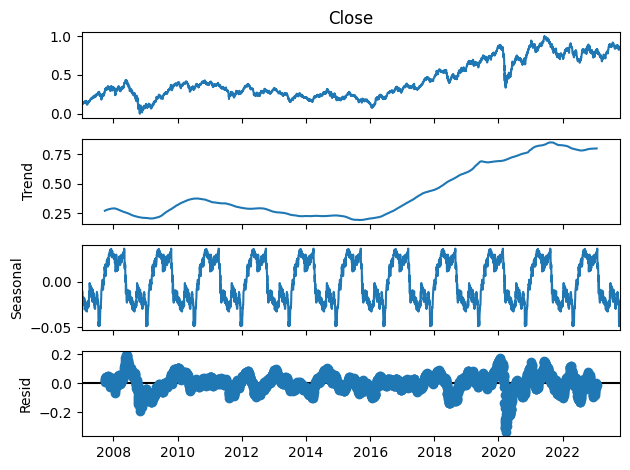

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Close'], model='additive',period=365)
result.plot()
plt.show()

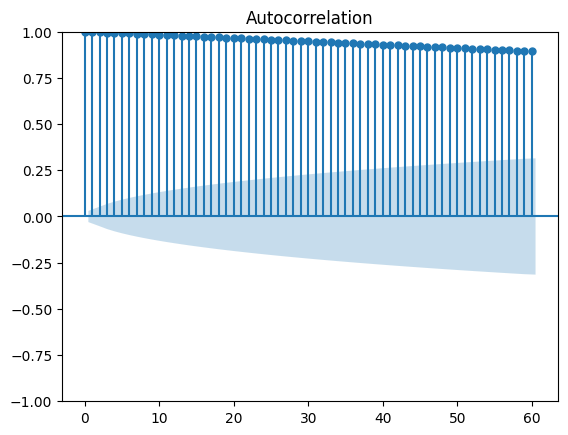

In [93]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Close'], lags=60)
plt.show()

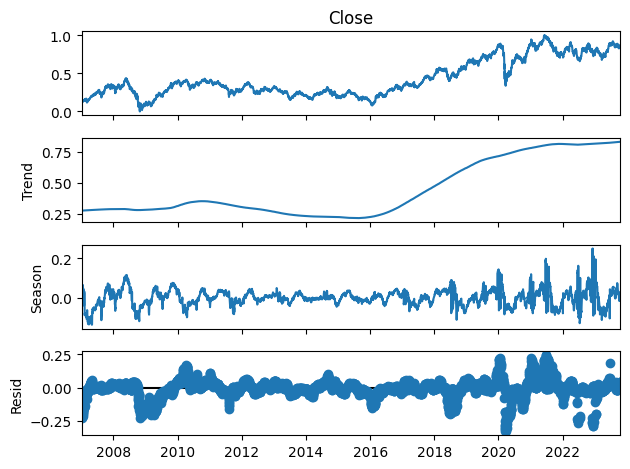

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(data['Close'], period=365,robust=True)#looking for pattern that repeats annualy
res = stl.fit()
fig = res.plot()

In [94]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^BVSP', '2007-01-01', '2023-09-22')
data2= data2[['Close']]
data2

last_60_days = data2[-look_back:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = X_test.reshape(-1,1,X_test.shape[1])
pred_price = lstm_model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 19ms/step
[[117930.92]]


In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^BVSP', '2023-09-23', '2023-09-26')
data2= data2[['Close']]
data2

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-09-25,115925.0


In [79]:
# Create lag features for the entire dataset
look_back = 60
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data, look_back, include_lag0)
lagged_data = lagged_data.dropna()  # Drop rows with NaN values
lagged_data

,Close,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60
Date,,,,,,,,,,,,,,,,,,,,,
2007-03-30,0.161534,0.157093,0.148499,0.155633,0.159955,0.158850,0.157774,0.159817,0.147186,0.140891,...,0.133056,0.134792,0.130599,0.127303,0.124056,0.132177,0.126405,0.143920,0.148114,0.157370
2007-04-02,0.159481,0.161534,0.157093,0.148499,0.155633,0.159955,0.158850,0.157774,0.159817,0.147186,...,0.130145,0.133056,0.134792,0.130599,0.127303,0.124056,0.132177,0.126405,0.143920,0.148114
2007-04-03,0.166300,0.159481,0.161534,0.157093,0.148499,0.155633,0.159955,0.158850,0.157774,0.159817,...,0.131240,0.130145,0.133056,0.134792,0.130599,0.127303,0.124056,0.132177,0.126405,0.143920
2007-04-04,0.168925,0.166300,0.159481,0.161534,0.157093,0.148499,0.155633,0.159955,0.158850,0.157774,...,0.128704,0.131240,0.130145,0.133056,0.134792,0.130599,0.127303,0.124056,0.132177,0.126405
2007-04-05,0.169842,0.168925,0.166300,0.159481,0.161534,0.157093,0.148499,0.155633,0.159955,0.158850,...,0.138078,0.128704,0.131240,0.130145,0.133056,0.134792,0.130599,0.127303,0.124056,0.132177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,0.845867,0.836137,0.827395,0.830582,0.828727,0.844890,0.859770,0.851541,0.837687,0.836364,...,0.893567,0.918927,0.913480,0.906908,0.895807,0.874750,0.869510,0.872362,0.876092,0.871079
2023-10-10,0.861468,0.845867,0.836137,0.827395,0.830582,0.828727,0.844890,0.859770,0.851541,0.837687,...,0.895511,0.893567,0.918927,0.913480,0.906908,0.895807,0.874750,0.869510,0.872362,0.876092
2023-10-11,0.864566,0.861468,0.845867,0.836137,0.827395,0.830582,0.828727,0.844890,0.859770,0.851541,...,0.912839,0.895511,0.893567,0.918927,0.913480,0.906908,0.895807,0.874750,0.869510,0.872362


In [80]:
# Save the final dataframe to a CSV file
lagged_data.to_csv('final_data.csv', index=False)  # Setting index=False to exclude the index column

# Print the first few rows of the final dataframe
print(lagged_data.head())

               Close      lag1      lag2      lag3      lag4      lag5  \
Date                                                                     
2007-03-30  0.161534  0.157093  0.148499  0.155633  0.159955  0.158850   
2007-04-02  0.159481  0.161534  0.157093  0.148499  0.155633  0.159955   
2007-04-03  0.166300  0.159481  0.161534  0.157093  0.148499  0.155633   
2007-04-04  0.168925  0.166300  0.159481  0.161534  0.157093  0.148499   
2007-04-05  0.169842  0.168925  0.166300  0.159481  0.161534  0.157093   

                lag6      lag7      lag8      lag9  ...     lag51     lag52  \
Date                                                ...                       
2007-03-30  0.157774  0.159817  0.147186  0.140891  ...  0.133056  0.134792   
2007-04-02  0.158850  0.157774  0.159817  0.147186  ...  0.130145  0.133056   
2007-04-03  0.159955  0.158850  0.157774  0.159817  ...  0.131240  0.130145   
2007-04-04  0.155633  0.159955  0.158850  0.157774  ...  0.128704  0.131240   
2007-04

   Feature  Importance
0     lag1    0.997560
1     lag2    0.000479
2     lag3    0.000095
4     lag5    0.000092
46   lag47    0.000084
7     lag8    0.000068
55   lag56    0.000067
5     lag6    0.000063
58   lag59    0.000060
12   lag13    0.000059


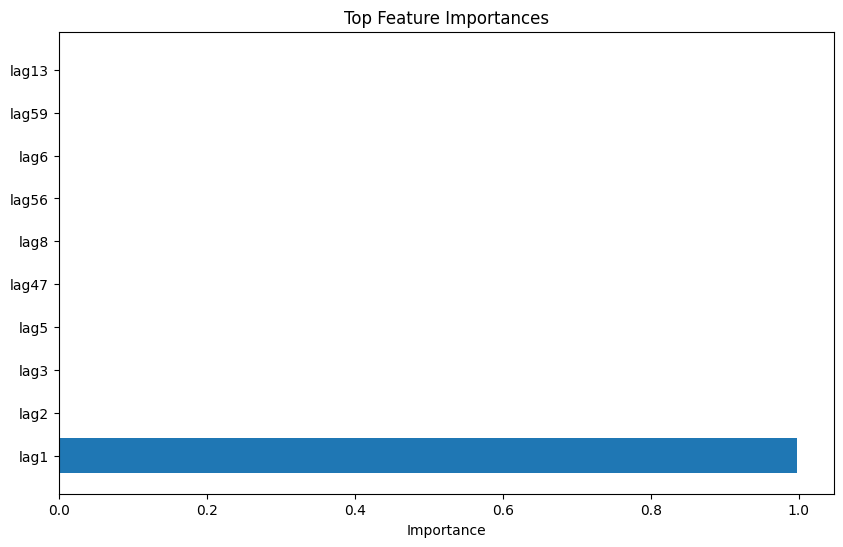

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Split the data into features (X) and the target variable (Y)
X = lagged_data.drop(columns='Close')
Y = lagged_data['Close']

# Create and fit the Decision Tree model
regression_tree = DecisionTreeRegressor()
regression_tree.fit(X, Y)

# Calculate feature importances
feature_importances = regression_tree.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features (adjust N as needed)
top_n = 10
print(importance_df.head(top_n))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n])
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.show()
#lag1 is way more important than others